# Тестовое задание Data Science
### Анонимизированные и преобразованные данные по заказам интернет-магазина

## Описание проекта

![Снимок экрана 2025-08-27 в 16.42.39.png](https://voltaic-soldier-ed2.notion.site/image/attachment%3Ad9f64690-7779-4b1b-832e-8ac182a448b6%3A%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA_%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0_2025-08-27_%D0%B2_16.42.39.png?table=block&id=25ca79f6-0092-80f9-a864-c82dff963c87&spaceId=2f8a79f6-0092-8133-8dd4-0003a5a3688e&width=1420&userId=&cache=v2)

`df_train.csv` и `df_test.csv`.

Задача состоит в предсказании расходов за отказ от покупки конкретного товара (колонка `item_losses`).

Требуется продемонстрировать умение обрабатывать данные, создавать признаки для моделей, обучать и валидировать модели, писать качественный код.

Для файла `df_test.csv` также требуется предсказать целевую переменную (предсказание сохранить в колонке `y_pred` в `csv` файле с сохранением порядка строк как в `df_test.csv`).

Качество предсказаний будет проверяться на тестовых данных `df_test.csv` по метрике `RMSE`.

**Описание данных:**

`order_id` - id заказа

`departure_country` - id страны отправления заказа

`departure_city` - id города отправления заказа

`departure_region` - id региона города отправления заказа

`arrival_country` - id страны получения заказа

`arrival_city` - id города получения заказа

`arrival_region` - id региона города получения заказа

`order_date` - дата заказа

`stock_departure_date` - время отправки со склада

`delivery_service_departure_date` - время отправки службой доставки

`client_arrival_date` - время доставки заказа в пункт получения

`item_type` - тип товара (для кого предназначен)

`client_keywords` - запрос для перехода клиента

`client_device_type` - устройство клиента

`client_browser` - браузер клиента

`item_package_type` - способ упаковки

`client_is_app` - заказ из приложения

`order_tracking_available` - отслеживание заказа

`brand_name` - название бренда

`item_id` - id товара

`item_category` - категория товара

`delivery_service_name` - название службы доставки

`type_prepayment` - тип предоплаты

`item_price` - цена товара

`item_losses` - расходы за отказ от покупки (целевая переменная)

## Импорты

In [1]:
# Установка всех нестандартных библиотек
!pip install numpy pandas matplotlib seaborn scikit-learn xgboost catboost lightgbm category_encoders optuna plotly

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import f1_score

import optuna
from optuna.integration import OptunaSearchCV
import optuna.distributions as dist

from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

plt.style.use('dark_background')

SEED = 1337

## Анализ данных

### Первичный осмотр

In [3]:
df_train = pd.read_csv('datasets/df_train.csv')
df_test = pd.read_csv('datasets/df_test.csv')

# Общая информация

def display_cols(df, n, k):
    for i in range(0, len(df.columns), n):
        display(df.iloc[:k, i:i+n])

print('TRAIN DATA INFO:')
df_train.info()
display_cols(df_train, 7, 2)

print('\nTEST DATA INFO:')
df_test.info()
display_cols(df_test, 7, 2)

TRAIN DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276205 entries, 0 to 276204
Data columns (total 26 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       276205 non-null  int64  
 1   order_id                         276205 non-null  object 
 2   departure_country                276205 non-null  int64  
 3   departure_city                   269885 non-null  float64
 4   departure_region                 276205 non-null  int64  
 5   arrival_country                  276205 non-null  int64  
 6   arrival_city                     267342 non-null  float64
 7   arrival_region                   276205 non-null  int64  
 8   order_date                       276205 non-null  object 
 9   stock_departure_date             276205 non-null  object 
 10  delivery_service_departure_date  276205 non-null  object 
 11  client_arrival_date              276205 non-null

,Unnamed: 0,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city
0,0,1c25f312-fefc-41ee-b328-8fe1fd188e75,12,565.0000,466,12,162.0000
1,1,c2a596a4-1a51-4269-b9f0-5c943c4f830d,12,361.0000,292,12,121.0000


,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date,item_type,client_keywords
0,888,2017-12-27 09:49:55,00-48-00 2018-01-02,12-04-00 2018-01-03,18-09-00 2018-01-03,0,"[326, 51, 37]"
1,351,2016-10-17 21:17:17,14-50-00 2016-11-02,21-33-00 2016-11-02,08-10-00 2016-11-03,0,[77]


,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available,brand_name,item_id
0,1,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],b1905241-ab8b-40e6-ae0a-8f614656f304
1,2,1,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,"['9e20fbd2-b0aa-4b6a-ae04-0fb3724f5a5d', '73d1...",5121ddf1-2a2b-4cff-a1db-7b8550799cd6


,item_category,delivery_service_name,type_prepayment,item_price,item_losses
0,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,1,443.2282,0.0000
1,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,589.4820,0.0000



TEST DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77837 entries, 0 to 77836
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       77837 non-null  int64  
 1   order_id                         77837 non-null  object 
 2   departure_country                77837 non-null  int64  
 3   departure_city                   76090 non-null  float64
 4   departure_region                 77837 non-null  int64  
 5   arrival_country                  77837 non-null  int64  
 6   arrival_city                     75418 non-null  float64
 7   arrival_region                   77837 non-null  int64  
 8   order_date                       77837 non-null  object 
 9   stock_departure_date             77837 non-null  object 
 10  delivery_service_departure_date  77837 non-null  object 
 11  client_arrival_date              77837 non-null  object 
 12  i

,Unnamed: 0,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city
0,0,3c39f09f-1f30-4d48-afd8-7ac959d4f2f3,12,125.0000,824,12,121.0000
1,1,660eec62-8547-4e5c-9981-afd14f2466f4,12,642.0000,635,12,193.0000


,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date,item_type,client_keywords
0,1732,2018-05-15 14:41:20,19-35-00 2018-07-05,19-35-00 2018-07-05,23-33-00 2018-07-05,0,NaN
1,215,2018-05-08 14:22:07,03-32-00 2018-07-26,05-19-00 2018-07-28,03-01-00 2018-07-30,0,NaN


,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available,brand_name,item_id
0,2,1,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],340bd249-e659-4257-a2a3-c1eb8271183e
1,1,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],85272285-4549-45be-a4f9-9e74687a21f5


,item_category,delivery_service_name,type_prepayment,item_price
0,5554bea4-f3cd-4432-bb13-73698f52de88,eec00286-b56b-44b0-8882-7b7022355a8f,0,630.3887
1,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,1,1436.8475


In [4]:
print('\n--- Пропуски в train ---')
display(
    df_train.isna()
    .sum()
    .to_frame('missing')
    .assign(**{'%': lambda x: (100 * x['missing'] / len(df_train)).round(2)})
    .sort_values('missing', ascending=False)
    .head(5)
)

print('\n--- Пропуски в test ---')
display(
    df_test.isna()
    .sum()
    .to_frame('missing')
    .assign(**{'%': lambda x: (100 * x['missing'] / len(df_test)).round(2)})
    .sort_values('missing', ascending=False)
    .head(5)
)

print('\n--- Уникальные значения ---')
unique_counts = df_train.nunique().sort_values(ascending=False)
display(unique_counts)


--- Пропуски в train ---


,missing,%
client_keywords,214992,77.8400
arrival_city,8863,3.2100
departure_city,6320,2.2900
order_id,0,0.0000
departure_region,0,0.0000



--- Пропуски в test ---


,missing,%
client_keywords,63118,81.0900
arrival_city,2419,3.1100
departure_city,1747,2.2400
departure_country,0,0.0000
Unnamed: 0,0,0.0000



--- Уникальные значения ---


Unnamed: 0                         276205
item_price                         270834
order_id                           193284
order_date                         192577
client_arrival_date                126786
delivery_service_departure_date    118719
stock_departure_date                99677
item_losses                         17908
client_keywords                      9012
item_id                              1866
arrival_region                       1395
departure_region                     1220
arrival_city                          671
departure_city                        587
client_device_type                    468
brand_name                            113
delivery_service_name                  25
arrival_country                        13
departure_country                      12
client_browser                          8
item_category                           6
item_package_type                       5
type_prepayment                         4
item_type                         

### Анализ 'item_losses'

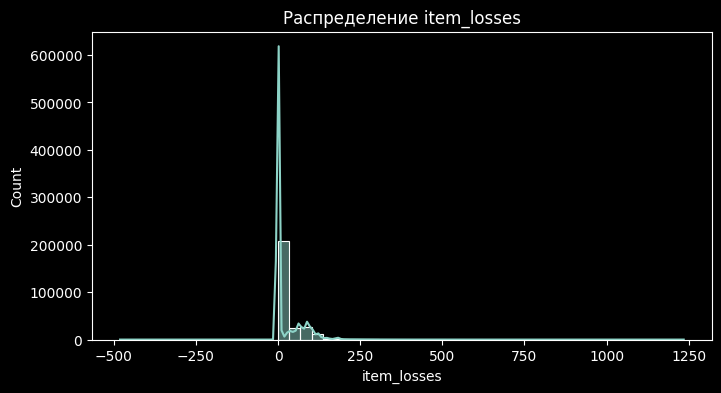

count   276205.0000
mean        23.5843
std         47.7635
min       -480.8484
25%          0.0000
50%          0.0000
75%         34.2092
max       1234.9547
Name: item_losses, dtype: float64

In [5]:
plt.figure(figsize=(8,4))
sns.histplot(df_train['item_losses'], bins=50, kde=True)
plt.title('Распределение item_losses')
plt.show()
display(df_train['item_losses'].describe())

In [6]:
neg_loses_count = len(df_train[(df_train['item_losses'] < 0)])
print(f'Строк с отрицательными затратами на возврат = {neg_loses_count}')

Строк с отрицательными затратами на возврат = 4


In [7]:
zero_ratio = len(df_train[df_train['item_losses'] == 0]) / len(df_train) * 100
print(f'Доля нулей: {zero_ratio:.1f}%')

Доля нулей: 72.5%


In [8]:
# подсчет нулевых и ненулевых строк для балансировки классов в дальнейшем
y_bin = (df_train['item_losses'] > 0).astype(int)
n_zeros = (y_bin == 0).sum()
n_nonzeros = (y_bin == 1).sum()

### Анализ 'client_keywords'

In [9]:
has_keywords = df_train['client_keywords'].notna().astype(int)
y_is_zero = (df_train['item_losses'] == 0).astype(int)

ct = pd.crosstab(has_keywords, y_is_zero, normalize='index')
print(ct)

corr = np.corrcoef(has_keywords, y_is_zero)[0, 1]
print('коэффициент корреляции Пирсона между наличием ключей и нулевми расходами:', corr)


item_losses          0      1
client_keywords              
0               0.2776 0.7224
1               0.2653 0.7347
коэффициент корреляции Пирсона между наличием ключей и нулевми расходами: 0.011429884879715276


Разница в вероятности нулевых расходов на возврат, между теми у кого есть ключевые слова и теми у кого нет - очень маленькая, корреляция Пирсона всего около 1%.

Наличие `client_keywords` само по себе почти ничего не даёт для предсказания нулей.

Может быть полезно не само наличие, а состав списка ([326, 51, 37] и т.д.).

Эти коды могут отражать категории запросов (например, 'доставка', 'возврат', 'скидка'),  тогда отдельные токены могут иметь связь с расходами

In [10]:
all_tokens = set()
for kw in df_train['client_keywords'].dropna():
    tokens = [t.strip() for t in kw.strip('[] ').split(',') if t.strip()]
    all_tokens.update(tokens)

print(f'Уникальных токенов: {len(all_tokens)}')
print(sorted(list(all_tokens))[:5])

Уникальных токенов: 2557
['1', '10', '100', '1000', '1001']


2557 уникальных значений, закодировать OneHot энкодером будет не рационально. возможно лучше просто сделать эмбеддинг

In [11]:
max_tokens = df_train['client_keywords'].dropna().apply(lambda s: len(s.strip('[] ').split(','))).max()
print(f'Максимальная длинна списка "ключевых слов": {max_tokens}')

Максимальная длинна списка "ключевых слов": 18


### Анализ 'item_price'

In [12]:
df_train['item_price'].describe()

count   276205.0000
mean       635.5851
std        565.0058
min          0.0000
25%        261.4262
50%        489.3992
75%        827.8641
max      13787.2410
Name: item_price, dtype: float64

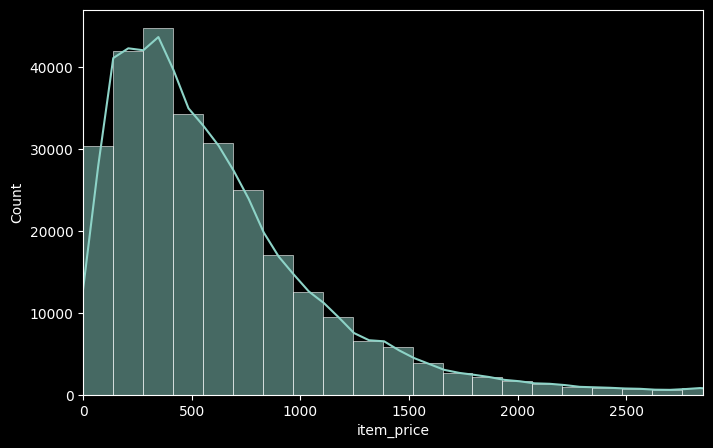

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(df_train['item_price'], bins=100, kde=True)
plt.xlim(0, df_train['item_price'].quantile(0.99))
plt.show()

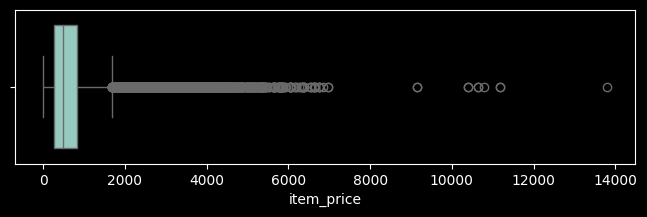

In [14]:
plt.figure(figsize=(8,2))
sns.boxplot(x=df_train['item_price'])
plt.show()

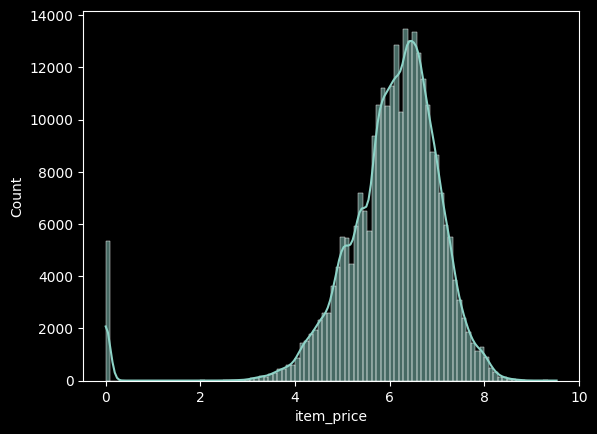

In [15]:
item_price_log = np.log1p(df_train['item_price'])

sns.histplot(item_price_log , bins=100, kde=True)
plt.show()

In [16]:
zero_prices = df_train[df_train['item_price'] == 0]
print(f'Нулевых цен: {len(zero_prices)} ({len(zero_prices)/len(df_train):.2%})')
zero_prices['item_category'].value_counts().head(10)

Нулевых цен: 5345 (1.94%)


item_category
ea77a36e-4b0c-4e8d-bf09-4c8398609ae1    2319
25f9f297-40a8-45d9-bb67-4b0f6dad1315    2038
5554bea4-f3cd-4432-bb13-73698f52de88     597
60959c0c-9c1a-434b-8442-3b8c2fc73655     341
243f0bd2-7e7b-4b32-96f9-5bd080948936      44
38541b4d-f0d3-4471-abbc-574f4f1779c8       6
Name: count, dtype: int64

In [17]:
order_sizes = df_train.groupby('order_id')['item_price'].transform('count')
is_zero_single = (df_train['item_price'] == 0) & (order_sizes == 1)
print('нулевая цена в заказах с одним товаром:', is_zero_single.sum())

нулевая цена в заказах с одним товаром: 787


- Распределение цен сильно правостороннее, длинный хвост до 13k+

- Boxplot показывает кучу выбросов (дорогие вещи сильно выделяются)

- Логарифмирование сильно исправkztn ситуацию: распределение становится ближе к нормальному, хвост сжимается

- Достаточно большое количество нулевых цен не похоже на ошибки и шум, гипотеза что это подарочные акции в придачу к другому товару тоже не подтверждается, есть и заказы с всего одним товаром и нулевой ценой

In [18]:
mean_prices = df_train.groupby('item_category')['item_price'].transform('mean')
df_train['price_dev_from_cat'] = df_train['item_price'] - mean_prices


### Выводы по анализу данных

#### Пропуски

`client_keywords` - 214k пропусков (~78% в train, ~81% в test). Использовать как фичу нецелесообразно, лучше выкинуть или оставить только как индикатор "есть ли keywords" или сколько их

`arrival_city` и `departure_city` - пропусков меньше (2–3%). Можно кодировать NaN как отдельное значение

#### Количественные признаки без изменений:

- `item_price`

- `order_tracking_available` - бинарный признак, кодировка не требуется, уже числовой тип данных

#### Обработка других признаков:

- `order_id` 193284 уникальных значений на трейне из 276205 записей. значительная часть записей принадлежат к одному заказу. из этого можно выделить признак количества товаров в заказе

- `client_keywords` - из этого сделаем признак количества ключевых слов в запросе из длинны списка в записи

- `departure_country`, `departure_city`, `departure_region`, `arrival_country`, `arrival_city`, `arrival_region` - из этих индексов можно сделать признаки того, является ли это доставкой в другую страну/регион/город

- `order_date`, `client_arrival_date`, `delivery_service_departure_date`, `stock_departure_date` - из этих признаков получить дельты времени между датой заказа и временем отправки со склада, временем отправки со склада и временем отправки службой доставки, временем отправки службой доставки и временем доставки заказа в пункт получения и общем временем от заказа до получения

- `delivery_service_name` (25), `client_browser` (8), `item_category` (6), `item_package_type` (5), `type_prepayment` (4), `item_type` (3) - нормальная кардинальность можно категориального признака:  можно закодировать с помощью one-hot энкодера

- `item_id` (1866), `client_device_type` (468), `brand_name` (113) - Высокая кардинальность категориального признака: нужно аккуратное кодирование

- `client_is_app` - нужно перевести из булева в числовой тип данных


#### Прочие замечания

- Большинство заказов без убытков (медиана = 0)

- У части заказов есть отрицательные значения убытков (min = -480), это выглядит подозрительно (ошибки в данных?). Нужно разобратся

## Формирование признаков и работа с пропусками и аномалиями

In [19]:
# удалим 4 отрицательные строки затрат
df_train = df_train[~(df_train['item_losses'] < 0)]

In [20]:
# Разделение фичей и таргета
X_train = df_train.drop(['item_losses'], axis=1)
y_train = df_train['item_losses']
y_train_bin = (y_train != 0).astype(int) # Нужно для обучения классификатора при использовании ZeroInflated подхода 

Обработку пропусков учтём в рамках пайплайна предобработки

In [21]:
# Классы для препроцессинга в рамках пайплайна

class PriceFeatureExtractor(BaseEstimator, TransformerMixin):
    '''
    Формирует признаки из цены товара:
       - логарифмированная цена
       - отклонение от средней по категории *
            * в случае новых категорий на тесте/валидации/инференсе, заполняем средней по датасету ценой
    '''
    
    def __init__(self, price_col, groupby_col):
        self.price_col = price_col
        self.groupby_col = groupby_col
        self.cat_avg_prices_ = {}
        self.global_avg_price_ = None

    def fit(self, X, y=None):
        if self.price_col in X.columns and self.groupby_col in X.columns:
            self.cat_avg_prices_ = (X.groupby(self.groupby_col)[self.price_col].mean().to_dict())
            self.global_avg_price_ = X[self.price_col].mean()
        return self

    def transform(self, X):
        X = X.copy()
        
        if self.price_col in X.columns:
            X[f'{self.price_col}_log'] = np.log1p(X[self.price_col])
        
        if self.price_col in X.columns and self.groupby_col in X.columns:
            avg_map = X[self.groupby_col].map(self.cat_avg_prices_)
            avg_map = avg_map.fillna(self.global_avg_price_)
            X['price_dev_from_cat'] = X[self.price_col] - avg_map
        
        return X

class DateFeatureExtractor(BaseEstimator, TransformerMixin):
    '''
    Извлекает временные признаки и вычисляет дельты времени этапов доставки до клиента
    Дли инициализации нужен список 4 колонок в порядке от заказа до получения
    '''
    
    def __init__(self, col):
        self.col = col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        X[self.col[0]] = pd.to_datetime(X[self.col[0]], errors='coerce')
        for i in range(1,4):
            X[self.col[i]] = pd.to_datetime(X[self.col[i]],
            format='%H-%M-%S %Y-%m-%d', errors='coerce')
        
        # Создание временных дельт (в часах)
        if all(c in X.columns for c in self.col):
            for i in range(3):
                X[f'delivery_{i+1}'] = (
                    X[self.col[i+1]] - X[self.col[i]]
                ).dt.total_seconds() / 3600

            X['delivery_full'] = (
                X[self.col[3]] - X[self.col[0]]
            ).dt.total_seconds() / 3600
        
        if 'item_price' in X.columns and 'delivery_full' in X.columns:
            X['price_per_hour'] = X['item_price'] / (X['delivery_full'] + 1)

        if all(col in X.columns for col in ['delivery_1', 'delivery_2', 'delivery_3']):
            X['delivery_speed'] = X['delivery_1'] / (X['delivery_2'] + X['delivery_3'] + 1) # соотношение "подготовки" к "транспортировке"
            X['total_transport_time'] = X['delivery_2'] + X['delivery_3']  # только транспорт
            X['prep_vs_transport'] = X['delivery_1'] / (X['total_transport_time'] + 1)

                
        # Извлечение признаков из даты заказа
        if self.col[0] in X.columns:
            X['order_hour'] = X[self.col[0]].dt.hour
            X['order_day_of_week'] = X[self.col[0]].dt.dayofweek
            X['order_month'] = X[self.col[0]].dt.month
            X['order_day_of_month'] = X[self.col[0]].dt.day
            X['is_weekend'] = (X[self.col[0]].dt.dayofweek >= 5).astype(int)
        
            # Час (суточный цикл)
            X['order_hour_sin'] = np.sin(2 * np.pi * X['order_hour'] / 24)
            X['order_hour_cos'] = np.cos(2 * np.pi * X['order_hour'] / 24)
            
            # День недели (недельный цикл)
            X['order_day_of_week_sin'] = np.sin(2 * np.pi * X['order_day_of_week'] / 7)
            X['order_day_of_week_cos'] = np.cos(2 * np.pi * X['order_day_of_week'] / 7)

            # День месяца (месячный цикл)
            X['order_day_of_month_sin'] = np.sin(2 * np.pi * X['order_day_of_month'] / 31)
            X['order_day_of_month_cos'] = np.cos(2 * np.pi * X['order_day_of_month'] / 31)
            
            # Месяц (годовой цикл)
            X['order_month_sin'] = np.sin(2 * np.pi * X['order_month'] / 12)
            X['order_month_cos'] = np.cos(2 * np.pi * X['order_month'] / 12)
        
        # Удаляем исходные колонки с датами (они больше не нужны)
        X = X.drop(columns=self.col, errors='ignore')
        
        return X

class GeographicFeatureExtractor(BaseEstimator, TransformerMixin):
    '''
    Создает географические бинарные признаки: 
        - международная посылка
        - в другой регион 
        - межгород
        - данные о городе отсутствуют
    '''

    def __init__(self, col):
        self.col = col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        if all(c in X.columns for c in self.col):
            X['is_international_delivery'] = (
                (X[self.col[0]].notna()) & (X[self.col[1]].notna()) &
                (X[self.col[0]].notna()) & (X[self.col[1]].notna())
                ).astype(int)
            X['is_interregional_delivery'] = (
                (X[self.col[2]].notna()) & (X[self.col[3]].notna()) &
                (X[self.col[2]].notna()) & (X[self.col[3]].notna())
                ).astype(int)
            X['is_intercity_delivery'] = (
                (X[self.col[4]].notna()) & (X[self.col[5]].notna()) &
                (X[self.col[4]].notna()) & (X[self.col[5]].notna())
                ).astype(int)
            X['missing_city_info'] = (X[self.col[4]].isna() | X[self.col[5]].isna()).astype(int)    
            
        # Дропаем колонки городов, они больше не нужны
        X = X.drop(columns=self.col, errors='ignore')
        
        return X

class OrderFeatureExtractor(BaseEstimator, TransformerMixin):
    '''
    Извлекает признак количества позиций в заказе
    '''
    
    def __init__(self, col):
        self.order_counts = {}
        self.col = col
    
    def fit(self, X, y=None):
        if self.col in X.columns:
            self.order_counts = X[self.col].value_counts().to_dict()
        return self
    
    def transform(self, X):
        X = X.copy()
        if self.col in X.columns:
            X['items_per_order'] = X[self.col].map(self.order_counts).fillna(1)
            
        X = X.drop(columns=[self.col], errors='ignore')
        return X

class KeywordsFeatureExtractor(BaseEstimator, TransformerMixin):
    '''
    Извлекает признаки из client_keywords через TF-IDF + SVD
    '''

    def __init__(self, col, n_components=36):
        self.col = col
        self.n_components = n_components
        self.vectorizer = TfidfVectorizer(token_pattern=r'\d+')
        self.svd = None

    def preprocess(self, keywords):
        if pd.isna(keywords):
            return ''
        return keywords.strip('[] ').replace(' ', '')

    def fit(self, X, y=None):
        texts = X[self.col].fillna('').apply(self.preprocess)
        X_tfidf = self.vectorizer.fit_transform(texts)
        n_comp = min(self.n_components, X_tfidf.shape[1])
        self.svd = TruncatedSVD(n_components=n_comp, random_state=SEED)
        self.svd.fit(X_tfidf)
        return self

    def transform(self, X):
        X_copy = X.copy()
        texts = X_copy[self.col].fillna('').apply(self.preprocess)
        X_tfidf = self.vectorizer.transform(texts)
        X_svd = self.svd.transform(X_tfidf)
        n_svd_features = X_svd.shape[1]

        for i in range(n_svd_features):
            X_copy[f'kw_emb_{i}'] = X_svd[:, i]

        X_copy = X_copy.drop(columns=[self.col])
        return X_copy

class BoolToNumTransformer(BaseEstimator, TransformerMixin):
    '''
    преобразыет булевы значения False/True в числовые 0/1
    '''

    def __init__(self, col):
        self.col = col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        for c in self.col:
            if c in X.columns:
                X[c] = X[c].astype(int)
        
        return X

class ColsDroper(BaseEstimator, TransformerMixin):
    '''
    Удаляет столбцы по списку
    '''

    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X = X.drop(columns=self.cols, errors="ignore")
        return X

In [22]:
# Формируем препроцессор для подготовки фичей
categorial_fetures = [
    'item_id', 'client_device_type', 'brand_name',
    'delivery_service_name', 'client_browser', 'item_category',
    'item_package_type', 'type_prepayment', 'item_type'
    ]

preprocessor = Pipeline([
    ('price_features', PriceFeatureExtractor(price_col='item_price', groupby_col='item_category')),
    ('date_features', DateFeatureExtractor(['order_date', 'stock_departure_date', 'delivery_service_departure_date', 'client_arrival_date'])),
    ('geographic_features', GeographicFeatureExtractor(['departure_country', 'arrival_country', 'departure_region', 'arrival_region', 'departure_city', 'arrival_city'])),
    ('order_features', OrderFeatureExtractor('order_id')),
    ('keywords_features', KeywordsFeatureExtractor('client_keywords')),
    ('bool_to_num', BoolToNumTransformer(['client_is_app'])),
    ('categorical_encoder', TargetEncoder(cols=categorial_fetures)),
    ('cols_droper', ColsDroper(['Unnamed: 0'])),
])
preprocessor_catboost = Pipeline([
    ('price_features', PriceFeatureExtractor(price_col='item_price', groupby_col='item_category')),
    ('date_features', DateFeatureExtractor(['order_date', 'stock_departure_date', 'delivery_service_departure_date', 'client_arrival_date'])),
    ('geographic_features', GeographicFeatureExtractor(['departure_country', 'arrival_country', 'departure_region', 'arrival_region', 'departure_city', 'arrival_city'])),
    ('order_features', OrderFeatureExtractor('order_id')),
    ('keywords_features', KeywordsFeatureExtractor('client_keywords')),
    ('bool_to_num', BoolToNumTransformer(['client_is_app'])),
    ('cols_droper', ColsDroper(['Unnamed: 0'])),
])

In [182]:
# подготавливаем фичи к обучению
preprocessor_pipeline = Pipeline([('preprocessor', preprocessor)])
preprocessor_catboost_pipeline = Pipeline([('preprocessor', preprocessor_catboost)])

X_train_preprocessed = preprocessor_pipeline.fit_transform(X_train, y_train)
X_train_catboost_preprocessed = preprocessor_catboost_pipeline.fit_transform(X_train, y_train)

X_test_preprocessed = preprocessor_pipeline.transform(df_test)
X_test_preprocessed = X_test_preprocessed[X_train_preprocessed.columns]

# Нужно для обучения регрессора при использовании ZeroInflated подхода 
mask_nonzero = y_train != 0
X_train_preprocessed_nonzero = X_train_preprocessed[mask_nonzero]
y_train_nonzero = y_train[mask_nonzero]

X_train_preprocessed.info()
display_cols(X_train_preprocessed, 6, 5)

<class 'pandas.core.frame.DataFrame'>
Index: 276201 entries, 0 to 276204
Data columns (total 76 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   item_type                  276201 non-null  float64
 1   client_device_type         276201 non-null  float64
 2   client_browser             276201 non-null  float64
 3   item_package_type          276201 non-null  float64
 4   client_is_app              276201 non-null  int64  
 5   order_tracking_available   276201 non-null  int64  
 6   brand_name                 276201 non-null  float64
 7   item_id                    276201 non-null  float64
 8   item_category              276201 non-null  float64
 9   delivery_service_name      276201 non-null  float64
 10  type_prepayment            276201 non-null  float64
 11  item_price                 276201 non-null  float64
 12  price_dev_from_cat         276201 non-null  float64
 13  item_price_log             276201 

,item_type,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available
0,24.6586,22.4445,24.7658,24.5270,1,0
1,24.6586,22.8798,22.5509,24.5270,1,0
2,24.6586,26.6221,24.7658,24.5270,1,0
3,24.6586,26.7011,24.7658,24.5270,1,0
4,24.6586,26.6221,24.7658,24.5270,1,0


,brand_name,item_id,item_category,delivery_service_name,type_prepayment,item_price
0,22.8566,14.9792,27.3573,21.7231,20.6442,443.2282
1,33.9371,32.9482,27.3573,22.8637,23.7205,589.4820
2,18.6607,19.7459,18.9924,22.8637,23.7205,110.9470
3,22.8566,18.9547,27.3573,22.8637,23.7205,793.9028
4,25.0757,22.6490,21.2650,22.8637,23.7205,1174.8069


,price_dev_from_cat,item_price_log,delivery_1,delivery_2,delivery_3,delivery_full
0,-382.2675,6.0963,134.9681,35.2667,6.0833,176.3181
1,-236.0138,6.3809,377.5453,6.7167,10.6167,394.8786
2,-351.4752,4.7180,242.8547,0.0000,3.3667,246.2214
3,-31.5929,6.6782,192.6681,0.0000,14.2333,206.9014
4,707.3985,7.0697,579.3247,6.0667,29.5167,614.9081


,price_per_hour,delivery_speed,total_transport_time,prep_vs_transport,order_hour,order_day_of_week
0,2.4996,3.1870,41.3500,3.1870,9,2
1,1.4890,20.5934,17.3333,20.5934,21,0
2,0.4488,55.6156,3.3667,55.6156,18,2
3,3.8187,12.6478,14.2333,12.6478,20,5
4,1.9074,15.8358,35.5833,15.8358,18,2


,order_month,order_day_of_month,is_weekend,order_hour_sin,order_hour_cos,order_day_of_week_sin
0,12,27,0,0.7071,-0.7071,0.9749
1,10,17,0,-0.7071,0.7071,0.0000
2,4,26,0,-1.0000,-0.0000,0.9749
3,7,1,1,-0.8660,0.5000,-0.9749
4,5,31,0,-1.0000,-0.0000,0.9749


,order_day_of_week_cos,order_day_of_month_sin,order_day_of_month_cos,order_month_sin,order_month_cos,is_international_delivery
0,-0.2225,-0.7248,0.6890,-0.0000,1.0000,1
1,1.0000,-0.2994,-0.9541,-0.8660,0.5000,1
2,-0.2225,-0.8486,0.5290,0.8660,-0.5000,1
3,-0.2225,0.2013,0.9795,-0.5000,-0.8660,1
4,-0.2225,-0.0000,1.0000,0.5000,-0.8660,1


,is_interregional_delivery,is_intercity_delivery,missing_city_info,items_per_order,kw_emb_0,kw_emb_1
0,1,1,0,6,0.0021,-0.0084
1,1,1,0,2,-0.0000,-0.0000
2,1,1,0,1,0.0000,0.0000
3,1,1,0,1,0.0000,0.0000
4,1,1,0,1,0.0000,0.0000


,kw_emb_2,kw_emb_3,kw_emb_4,kw_emb_5,kw_emb_6,kw_emb_7
0,-0.0023,0.0036,-0.0038,-0.0075,0.0391,0.0092
1,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


,kw_emb_8,kw_emb_9,kw_emb_10,kw_emb_11,kw_emb_12,kw_emb_13
0,-0.0193,-0.0117,-0.0420,-0.0135,-0.0163,-0.0000
1,-0.0000,0.0000,0.0000,0.0000,-0.0000,1.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


,kw_emb_14,kw_emb_15,kw_emb_16,kw_emb_17,kw_emb_18,kw_emb_19
0,-0.0092,0.0056,0.0321,0.1259,0.0251,-0.0000
1,-0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


,kw_emb_20,kw_emb_21,kw_emb_22,kw_emb_23,kw_emb_24,kw_emb_25
0,-0.0005,0.0417,0.0658,-0.1515,0.1104,-0.0545
1,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


,kw_emb_26,kw_emb_27,kw_emb_28,kw_emb_29,kw_emb_30,kw_emb_31
0,0.7067,0.0448,0.0067,-0.0361,0.0860,-0.0006
1,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


,kw_emb_32,kw_emb_33,kw_emb_34,kw_emb_35
0,0.0657,-0.0191,-0.0244,0.0457
1,0.0000,-0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000


## Обучение моделей

In [24]:
# создаём объект для кросс валидации
cv = KFold(n_splits=3, random_state=SEED, shuffle=True)

In [ ]:
# переменные для сохранения данных по моделям
results = pd.DataFrame(columns=['Model', 'RMSE'])
best_params = {}

In [ ]:
# Функции для анализа и построения графиков Optuna

def plot_optuna_results(model_name: str, optuna_obj: OptunaSearchCV, greater_is_better: bool = True, metric_name: str = None):
    '''
    Построение графиков результатов Optuna: история, распределение, важность параметров
    params:
        model_name: str
            Имя модели
        optuna_obj: OptunaSearchCV
            Объект OptunaSearchCV
        greater_is_better: bool
            Большее значение метрики лучше?
        metric_name: str
            Отображаемое имя метрики (по умолчанию F1 или RMSE в зависимости от параметра greater_is_better)
    '''
    study = optuna_obj.study_
    completed = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    if not completed:
        print("Нет завершённых trials для построения графиков")
        return
    
    records = []
    for t in completed:
        raw = t.value
        display = raw if greater_is_better else -raw
        records.append({"trial": t, "raw": raw, "display": display})

    trial_numbers = [r["trial"].number for r in records]
    display_values = [r["display"] for r in records]

    if metric_name is None:
        metric_name = "F1" if greater_is_better else "RMSE"

    try:
        param_importance = optuna.importance.get_param_importances(study) or {}
    except Exception:
        param_importance = {}
  
    # Создаём сетку под графики
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(f'История оптимизации', f'Распределение {metric_name}', 'Важность параметров', f'Лучшие 10 результатов'),
        specs=[
            [{'secondary_y': False}, {'secondary_y': False}],
            [{'secondary_y': False}, {'type': 'table'}]
        ],
        horizontal_spacing=0.08,
        vertical_spacing=0.12    
    )

    # 1. История и лучший
    fig.add_trace(
        go.Scatter(x=trial_numbers, y=display_values, mode='markers', name='Trial', opacity=0.7), 
        row=1, col=1)
    
    best_so_far = []
    if greater_is_better:
        cur_best = -float("inf")
        for v in display_values:
            if v > cur_best:
                cur_best = v
            best_so_far.append(cur_best)
    else:
        cur_best = float("inf")
        for v in display_values:
            if v < cur_best:
                cur_best = v
            best_so_far.append(cur_best)

    fig.add_trace(
        go.Scatter(x=trial_numbers, y=best_so_far, mode='lines', name=f'Best {metric_name}', line=dict(color='red', width=3)), 
        row=1, col=1)
    
    # 2. Распределение
    fig.add_trace(
        go.Histogram(x=display_values, nbinsx=20, name=f'Распределение {metric_name}', opacity=0.75), 
        row=1, col=2)
    
    # 3. Важность параметров

    if param_importance:
        fig.add_trace(
            go.Bar(x=list(param_importance.values()), y=[k.replace('model__','') for k in param_importance.keys()],
                    orientation='h', marker_color='lightgreen', name='Важность'),
            row=2, col=1)
    else:
        fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers", showlegend=False),row=2, col=1)
    
    # 4. Топ 10 лучших trial

    if greater_is_better:
        top_sorted = sorted(records, key=lambda r: r['display'], reverse=True)[:10]
    else:
        top_sorted = sorted(records, key=lambda r: r['display'])[:10]

    table_trials = [r['trial'].number for r in top_sorted]
    table_vals = [round(r["display"], 6) for r in top_sorted]
    
    fig.add_trace(
        go.Table(
            header=dict(values=['Trial', metric_name], fill_color='#222', font_color='white'),
            cells=dict(values=[table_trials, table_vals], fill_color='#111', font_color='white')
        ),
        row=2, col=2
    )
    

    fig.update_layout(height=800, title_text=f'Оптимизация: {model_name} ({metric_name})', template='plotly_dark')
    fig.show()

    # Параллельные координаты
    if param_importance and len(param_importance) > 0 and len(records) > 1:
        try:
            parallel_fig = optuna.visualization.plot_parallel_coordinate(study, params=list(param_importance.keys())[:8])
            
            parallel_fig.update_traces(line=dict(
                color=display_values,
                colorscale='Rainbow',
                showscale=True,
                reversescale=not greater_is_better,
                colorbar=dict(title=metric_name),
                ))

            parallel_fig.update_layout(height=600, title=f"Параллельные координаты: {model_name}", template='plotly_dark')
            parallel_fig.show()
        except Exception as e:
            print("Не удалось нарисовать параллельные координаты:", e)

def analyze_optuna(model_name: str, optuna_obj: OptunaSearchCV, results: pd.DataFrame, best_params: dict, n: int):
    '''
    Вывод лучшего скора и параметров Optuna, построение графиков
    params:
        model_name: str
            Имя модели
        optuna_obj: OptunaSearchCV
            Объект OptunaSearchCV
        results: pd.DataFrame
            Датафрейм для сохранения результатов в виде ['Имя модели', метрика] 
        best_params: dict
            Словарь для сохранения словарей с параметрами. ключ это имя модели
        n: int
            индекс в словаре результатов
    '''

    print(f'Результаты по {model_name} модели')
    print('~' * 79)
    best_score = -optuna_obj.cv_results_['mean_test_score'][optuna_obj.best_index_]
    best_params = optuna_obj.best_params_
    print(f"Лучший RMSE: {best_score:.4f}")
    print(f"Лучшие параметры: {best_params}")
    plot_optuna_results(model_name, optuna_obj, greater_is_better=False)

    # зафиксировали
    results.loc[n] = [model_name, best_score]
    best_params[model_name] = best_params

### LinearRegression model

In [125]:
lin_model = LinearRegression()

lin_rmse = -cross_val_score(
    lin_model, 
    X_train_preprocessed, 
    y_train,
    cv=cv, 
    scoring='neg_root_mean_squared_error'
    ).mean()

results.loc[len(results)] = ['LinearRegression', lin_rmse]
print('LinearRegression')
print('~' * 79)
print('Средний RMSE на кросс-валидации:', round(lin_rmse, 4))

LinearRegression
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Средний RMSE на кросс-валидации: 46.0243


### XG Boost model

In [ ]:
xgb_model = XGBRegressor(
    random_state=SEED,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_jobs=1
)

xgb_params = {
    'n_estimators': dist.IntDistribution(1200, 1600),
    'max_depth': dist.IntDistribution(12, 20),
    'learning_rate': dist.FloatDistribution(0.01, 0.1),
    'subsample': dist.FloatDistribution(0.9, 1.0),
    'colsample_bytree': dist.FloatDistribution(0.7, 1.0),
}

xgb_optuna = OptunaSearchCV(
    xgb_model,
    xgb_params,
    cv=cv,
    n_trials=200,
    scoring='neg_root_mean_squared_error',
    refit=True,
    random_state=SEED,
    n_jobs=1,
    verbose=1,
    timeout=1800,
    callbacks=[
        optuna.study.MaxTrialsCallback(200, states=(optuna.trial.TrialState.COMPLETE,)),
    ]
)

xgb_optuna.fit(X_train_preprocessed, y_train)
best_xgb_model = xgb_optuna.best_estimator_

[I 2025-09-26 19:38:16,235] A new study created in memory with name: no-name-9a7aa62d-3f31-4780-b21d-253944859898
[I 2025-09-26 19:42:52,058] Trial 0 finished with value: -36.990537146217406 and parameters: {'n_estimators': 1175, 'max_depth': 14, 'learning_rate': 0.12371698374615214, 'subsample': 0.9221752618562471, 'colsample_bytree': 0.8380119505895964}. Best is trial 0 with value: -36.990537146217406.
[I 2025-09-26 19:44:07,776] Trial 1 finished with value: -37.389528314207666 and parameters: {'n_estimators': 1007, 'max_depth': 10, 'learning_rate': 0.13228431108922753, 'subsample': 0.849395295267661, 'colsample_bytree': 0.5083169432081802}. Best is trial 0 with value: -36.990537146217406.
[I 2025-09-26 19:46:10,798] Trial 2 finished with value: -37.04155667096518 and parameters: {'n_estimators': 1176, 'max_depth': 11, 'learning_rate': 0.1312262681151124, 'subsample': 0.8853829515398185, 'colsample_bytree': 0.7462562188425411}. Best is trial 0 with value: -36.990537146217406.
[I 2025

In [160]:
analyze_optuna(
        'XGBoost', 
        xgb_optuna, 
        results, 
        best_params,
        1
        )

Результаты по XGBoost модели
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Лучший RMSE: 36.4339
Лучшие параметры: {'n_estimators': 1300, 'max_depth': 15, 'learning_rate': 0.05787947018973545, 'subsample': 0.9697904458344794, 'colsample_bytree': 0.7113488210158083}


![xgb1](images/xgb1.png)
![xgb2](images/xgb2.png)

### Catboost model

In [ ]:
cat_model = CatBoostRegressor(
    random_seed=SEED,
    task_type='GPU',
    verbose=False,
)

cat_params = {
    'iterations': dist.IntDistribution(800, 1200),
    'depth': dist.IntDistribution(10, 20),
    'learning_rate': dist.FloatDistribution(0.1, 0.3),
    'l2_leaf_reg': dist.FloatDistribution(0.1, 2, log=True),
}

cat_optuna = OptunaSearchCV(
    cat_model,
    cat_params,
    cv=cv,
    n_trials=200,
    scoring='neg_root_mean_squared_error',
    refit=True,
    random_state=SEED,
    n_jobs=1,
    verbose=1,
    timeout=1800,
    callbacks=[
        optuna.study.MaxTrialsCallback(200, states=(optuna.trial.TrialState.COMPLETE,)),
    ]
)

cat_optuna.fit(X_train_catboost_preprocessed, y_train, cat_features=categorial_fetures)
best_cat_model = cat_optuna.best_estimator_

[I 2025-09-26 20:53:02,764] A new study created in memory with name: no-name-39964ae6-0fde-4ae1-a418-5a987eaff865
[I 2025-09-26 20:55:45,553] Trial 0 finished with value: -40.9501423558033 and parameters: {'iterations': 800, 'depth': 9, 'learning_rate': 0.15000000000000002, 'l2_leaf_reg': 4.760258082340148}. Best is trial 0 with value: -40.9501423558033.
[I 2025-09-26 20:57:05,835] Trial 1 finished with value: -44.858809028277186 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.02, 'l2_leaf_reg': 10.404327914104774}. Best is trial 0 with value: -40.9501423558033.
[I 2025-09-26 20:58:05,228] Trial 2 finished with value: -43.925948700027014 and parameters: {'iterations': 700, 'depth': 4, 'learning_rate': 0.09, 'l2_leaf_reg': 0.9190264273493329}. Best is trial 0 with value: -40.9501423558033.
[I 2025-09-26 21:00:32,783] Trial 3 finished with value: -41.58265871475727 and parameters: {'iterations': 1000, 'depth': 7, 'learning_rate': 0.13, 'l2_leaf_reg': 1.445053162795075

In [161]:
analyze_optuna(
        'CatBoost', 
        cat_optuna, 
        results, 
        best_params,
        2
        )

Результаты по CatBoost модели
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Лучший RMSE: 38.6835
Лучшие параметры: {'iterations': 900, 'depth': 12, 'learning_rate': 0.19, 'l2_leaf_reg': 0.5020238208633997}


![catboost1](images/catboost1.png)
![catboost2](images/catboost2.png)

### LihgtGBM model

In [48]:
lgbm_model = LGBMRegressor(
    random_state=SEED,
    device='gpu',
    verbose=-1,
    n_jobs=1
)

lgbm_params = {
    'n_estimators': dist.IntDistribution(600, 1200),
    'max_depth': dist.IntDistribution(10, 24),
    'learning_rate': dist.FloatDistribution(0.1, 0.3),
    'num_leaves': dist.IntDistribution(40, 120),
}

lgbm_optuna = OptunaSearchCV(
    lgbm_model,
    lgbm_params,
    cv=cv,
    n_trials=200,
    scoring='neg_root_mean_squared_error',
    refit=True,
    random_state=SEED,
    n_jobs=1,
    verbose=1,
    timeout=1800,
    callbacks=[
        optuna.study.MaxTrialsCallback(200, states=(optuna.trial.TrialState.COMPLETE,)),
    ]
)

lgbm_optuna.fit(X_train_preprocessed, y_train)
best_lgbm_model = lgbm_optuna.best_estimator_

[I 2025-09-26 22:15:48,607] A new study created in memory with name: no-name-54f00103-f220-4d7b-8e62-5df609df9a1d
[I 2025-09-26 22:17:54,435] Trial 0 finished with value: -39.04895306149868 and parameters: {'n_estimators': 862, 'max_depth': 19, 'learning_rate': 0.24743396749230429, 'num_leaves': 89}. Best is trial 0 with value: -39.04895306149868.
[I 2025-09-26 22:20:57,011] Trial 1 finished with value: -39.00921249280598 and parameters: {'n_estimators': 1107, 'max_depth': 10, 'learning_rate': 0.11307396060810149, 'num_leaves': 106}. Best is trial 1 with value: -39.00921249280598.
[I 2025-09-26 22:22:11,407] Trial 2 finished with value: -40.129680411809005 and parameters: {'n_estimators': 748, 'max_depth': 10, 'learning_rate': 0.18817341121683526, 'num_leaves': 53}. Best is trial 1 with value: -39.00921249280598.
[I 2025-09-26 22:24:12,776] Trial 3 finished with value: -39.17530415396815 and parameters: {'n_estimators': 1088, 'max_depth': 16, 'learning_rate': 0.22312810942127054, 'num_

In [162]:
analyze_optuna(
        'LightGBM', 
        lgbm_optuna, 
        results, 
        best_params,
        3
        )

Результаты по LightGBM модели
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Лучший RMSE: 38.7156
Лучшие параметры: {'n_estimators': 953, 'max_depth': 15, 'learning_rate': 0.22582167845724557, 'num_leaves': 103}


![lgbm1](images/lgbm1.png)
![lgbm2](images/lgbm2.png)

### ZeroInflated подход с моделями Catboost

In [166]:
class ZeroInflatedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, classifier, regressor, threshold=0.5, use_log_transform=True):
        self.classifier = classifier
        self.regressor = regressor
        self.threshold = threshold
        self.use_log_transform = use_log_transform

    def fit(self, X, y):
        y_bin = (y > 0).astype(int)

        self.classifier_ = clone(self.classifier)
        self.classifier_.fit(X, y_bin)

        mask = y > 0
        if np.any(mask):
            y_reg = y[mask]
            if self.use_log_transform:
                y_reg = np.log1p(y_reg)
            
            self.regressor_ = clone(self.regressor)
            self.regressor_.fit(X[mask], y_reg)

        return self

    def predict(self, X):
        prob_nonzero = self.classifier_.predict_proba(X)[:, 1]
        is_nonzero = prob_nonzero >= self.threshold

        y_pred = np.zeros(len(X))
        if np.any(is_nonzero):
            y_pred_reg = self.regressor_.predict(X[is_nonzero])
            
            if self.use_log_transform:
                y_pred_reg = np.expm1(y_pred_reg)
            
            y_pred[is_nonzero] = np.clip(y_pred_reg, 0, None)
        
        return y_pred
    
def analyze_zir_optuna(model_name: str,
                       cls_optuna: OptunaSearchCV,
                       reg_optuna: OptunaSearchCV, 
                       X: pd.DataFrame, 
                       y: pd.Series, 
                       cls_threshold: float, 
                       results: pd.DataFrame,
                       best_params: dict, 
                       n: int
                       ):
    '''
    Анализ двух Optuna (классификатор и регрессор), вывод и сохранение лучших скорoв и параметров, построение графиков
    params:
        model_name: str
            Имя модели
        cls_optuna: OptunaSearchCV
            объект OptunaSearchCV для классификатора из ZeroInflatedRegressor
        reg_optuna: OptunaSearchCV
            объект OptunaSearchCV для регрессора из ZeroInflatedRegressor
        X: pd.DataFrame
            pandas Датасет фичей для измерения скора на кросс валидации
        y: pd.Series
            pandas вектор целевого показателя для измерения скора на кросс валидации
        cls_threshold: float
            порог уверенности для классификатора из ZeroInflatedRegressor
        results: pd.DataFrame
            Датафрейм для сохранения результатов в виде ['Имя модели', метрика] 
        best_params: dict
            Словарь для сохранения словарей с параметрами. ключ это имя модели
        n: int
            индекс в словаре результатов
    '''

    print(f'Результаты по {model_name} модели')

    # --- Классификатор ---
    cls_best_score = cls_optuna.cv_results_['mean_test_score'][cls_optuna.best_index_]
    cls_best_params = cls_optuna.best_params_
    print(f"{'='*50}\nКлассификатор\n{'='*50}")
    print(f"Лучший F1: {cls_best_score:.4f}")
    print(f"Лучшие параметры: {cls_best_params}")
    

    # --- Регрессор ---
    reg_best_score = -reg_optuna.cv_results_['mean_test_score'][reg_optuna.best_index_]
    reg_best_params = reg_optuna.best_params_
    print(f"{'='*50}\nРегрессор\n{'='*50}")
    print(f"Лучший RMSE: {reg_best_score:.4f}")
    print(f"Лучшие параметры: {reg_best_params}")

    # --- Итоговый RMSE через ZeroInflatedRegressor ---
    zir = ZeroInflatedRegressor(
        cls_optuna.best_estimator_, 
        reg_optuna.best_estimator_, 
        threshold=cls_threshold
        )
   
    overall_rmse = -cross_val_score(zir, X, y, cv=cv, scoring='neg_root_mean_squared_error').mean()
    print(f"Общий RMSE ZeroInflated (CV): {overall_rmse:.4f}")

    # Построение графиков
    plot_optuna_results(f'{model_name}_Classifier', cls_optuna)
    plot_optuna_results(f'{model_name}_Regressor', reg_optuna, greater_is_better=False)

    # зафиксировали
    results.loc[n] = [model_name, overall_rmse]
    best_params[f'zip_{model_name}_classifier'] = cls_best_params
    best_params[f'zip_{model_name}_regressor'] = reg_best_params

In [184]:
xgb_cls_model = XGBClassifier(
    random_state=SEED,
    tree_method='gpu_hist',
    use_label_encoder=False,
    eval_metric='logloss',
)

xgb_cls_params = {
    "n_estimators": dist.IntDistribution(800, 1600),
    "max_depth": dist.IntDistribution(4, 16),
    "learning_rate": dist.FloatDistribution(0.01, 0.2),
    "reg_lambda": dist.FloatDistribution(0.5, 20, log=True),
    "subsample": dist.FloatDistribution(0.5, 1.0),
    "colsample_bytree": dist.FloatDistribution(0.5, 1.0),
}

xgb_cls_optuna = OptunaSearchCV(
    xgb_cls_model,
    xgb_cls_params,
    cv=cv,
    n_trials=200,
    scoring="accuracy",
    refit=True,
    random_state=SEED,
    n_jobs=1,
    verbose=1,
    timeout=3600,
    callbacks=[
        optuna.study.MaxTrialsCallback(200, states=(optuna.trial.TrialState.COMPLETE,)),
    ],
)

xgb_cls_optuna.fit(X_train_preprocessed, y_train_bin)
best_xgb_cls_model = xgb_cls_optuna.best_estimator_

[I 2025-09-27 03:13:17,207] A new study created in memory with name: no-name-25f757ce-664d-4bf1-b1cd-b8817affa77e
[I 2025-09-27 03:14:56,861] Trial 0 finished with value: 0.8711518061122154 and parameters: {'n_estimators': 1150, 'max_depth': 12, 'learning_rate': 0.15006226911768908, 'reg_lambda': 4.760258082340148, 'subsample': 0.9225149382369955, 'colsample_bytree': 0.5089093075686137}. Best is trial 0 with value: 0.8711518061122154.
[I 2025-09-27 03:17:06,353] Trial 1 finished with value: 0.8712024938360107 and parameters: {'n_estimators': 852, 'max_depth': 14, 'learning_rate': 0.056925530504277885, 'reg_lambda': 0.5398593273569089, 'subsample': 0.7204335280420882, 'colsample_bytree': 0.582505648087539}. Best is trial 1 with value: 0.8712024938360107.
[I 2025-09-27 03:18:16,220] Trial 2 finished with value: 0.8658513184239015 and parameters: {'n_estimators': 1450, 'max_depth': 9, 'learning_rate': 0.12697170395020702, 'reg_lambda': 1.4450531627950758, 'subsample': 0.6419389971116406, 

In [185]:
# Подбор порога
y_proba = cross_val_predict(
    best_xgb_cls_model, 
    X_train_preprocessed, 
    y_train_bin, 
    cv=cv, 
    method='predict_proba'
)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []
for i, t in enumerate(thresholds, start=1):
    y_pred = (y_proba >= t).astype(int)
    score = f1_score(y_train_bin, y_pred)
    f1_scores.append(score)
    print(f"{i}/{len(thresholds)} | threshold={t:.3f} | f1={score:.4f}")
xgb_cls_best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Лучший threshold по F1: {xgb_cls_best_threshold:.2f}")

1/80 | threshold=0.100 | f1=0.7094
2/80 | threshold=0.110 | f1=0.7135
3/80 | threshold=0.120 | f1=0.7167
4/80 | threshold=0.130 | f1=0.7199
5/80 | threshold=0.140 | f1=0.7228
6/80 | threshold=0.150 | f1=0.7251
7/80 | threshold=0.160 | f1=0.7267
8/80 | threshold=0.170 | f1=0.7281
9/80 | threshold=0.180 | f1=0.7296
10/80 | threshold=0.190 | f1=0.7310
11/80 | threshold=0.200 | f1=0.7321
12/80 | threshold=0.210 | f1=0.7328
13/80 | threshold=0.220 | f1=0.7339
14/80 | threshold=0.230 | f1=0.7345
15/80 | threshold=0.240 | f1=0.7350
16/80 | threshold=0.250 | f1=0.7358
17/80 | threshold=0.260 | f1=0.7362
18/80 | threshold=0.270 | f1=0.7362
19/80 | threshold=0.280 | f1=0.7364
20/80 | threshold=0.290 | f1=0.7369
21/80 | threshold=0.300 | f1=0.7368
22/80 | threshold=0.310 | f1=0.7367
23/80 | threshold=0.320 | f1=0.7370
24/80 | threshold=0.330 | f1=0.7368
25/80 | threshold=0.340 | f1=0.7366
26/80 | threshold=0.350 | f1=0.7366
27/80 | threshold=0.360 | f1=0.7363
28/80 | threshold=0.370 | f1=0.7360
2

In [186]:
xgb_reg_model = XGBRegressor(
    random_state=SEED,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_jobs=1
)

xgb_reg_params = {
    'n_estimators': dist.IntDistribution(1200, 1600),
    'max_depth': dist.IntDistribution(12, 20),
    'learning_rate': dist.FloatDistribution(0.01, 0.1),
    'subsample': dist.FloatDistribution(0.9, 1.0),
    'colsample_bytree': dist.FloatDistribution(0.7, 1.0),
}

xgb_reg_optuna = OptunaSearchCV(
    xgb_reg_model,
    xgb_reg_params,
    cv=cv,
    n_trials=200,
    scoring='neg_root_mean_squared_error',
    refit=True,
    random_state=SEED,
    n_jobs=1,
    verbose=1,
    timeout=3600,
    callbacks=[
        optuna.study.MaxTrialsCallback(200, states=(optuna.trial.TrialState.COMPLETE,)),
    ]
)

xgb_reg_optuna.fit(X_train_preprocessed[y_train > 0], y_train[y_train > 0])
best_xgb_reg_model = xgb_reg_optuna.best_estimator_

[I 2025-09-27 04:19:37,244] A new study created in memory with name: no-name-5933a85d-cb19-468a-91f1-ce7325542b07
[I 2025-09-27 04:38:44,904] Trial 0 finished with value: -29.820813856152842 and parameters: {'n_estimators': 1375, 'max_depth': 17, 'learning_rate': 0.07634528537153693, 'subsample': 0.9610876309281235, 'colsample_bytree': 0.9535089629421973}. Best is trial 0 with value: -29.820813856152842.
[I 2025-09-27 04:40:47,572] Trial 1 finished with value: -28.6142751089527 and parameters: {'n_estimators': 1207, 'max_depth': 12, 'learning_rate': 0.08405587998030478, 'subsample': 0.9246976476338304, 'colsample_bytree': 0.7062377074061351}. Best is trial 1 with value: -28.6142751089527.
[I 2025-09-27 04:43:50,226] Trial 2 finished with value: -29.240784464196953 and parameters: {'n_estimators': 1376, 'max_depth': 13, 'learning_rate': 0.08310364130360118, 'subsample': 0.9426914757699093, 'colsample_bytree': 0.8846921641319058}. Best is trial 1 with value: -28.6142751089527.
[I 2025-09

In [187]:
analyze_zir_optuna(
    'XGBoost_zir',
    xgb_cls_optuna,
    xgb_reg_optuna,
    X_train_preprocessed,
    y_train,
    xgb_cls_best_threshold,
    results,
    best_params,
    4
    )

Результаты по XGBoost_zir модели
Классификатор
Лучший F1: 0.8737
Лучшие параметры: {'n_estimators': 1239, 'max_depth': 15, 'learning_rate': 0.09303645358606316, 'reg_lambda': 0.7058487033109733, 'subsample': 0.9687449594034963, 'colsample_bytree': 0.5619417714322633}
Регрессор
Лучший RMSE: 28.6143
Лучшие параметры: {'n_estimators': 1207, 'max_depth': 12, 'learning_rate': 0.08405587998030478, 'subsample': 0.9246976476338304, 'colsample_bytree': 0.7062377074061351}
Общий RMSE ZeroInflated (CV): 40.8691


![xgb_cls_zir1](images/xgb_cls_zir1.png)
![xgb_cls_zir2](images/xgb_cls_zir2.png)
![xgb_reg_zir1](images/xgb_reg_zir1.png)
![xgb_reg_zir2](images/xgb_reg_zir2.png)

### Сравнение моделей

In [188]:
print('='*60)
print('ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ')
print('='*60)
print(results.sort_values('RMSE'))
print()

print('Лучшие параметры по моделям:')
for model_name, params in best_params.items():
    print(f'\n{model_name}:')
    for param, value in params.items():
        print(f'  {param}: {value}')

best_model_name = results.loc[results['RMSE'].idxmin(), 'Model']
best_rmse = results['RMSE'].min()

print(f'\nПОБЕДИТЕЛЬ: {best_model_name} с RMSE: {best_rmse:.4f}')
print('='*60)

ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ
              Model    RMSE
1           XGBoost 36.4339
2          CatBoost 38.6835
3          LightGBM 38.7156
4       XGBoost_zir 40.8691
0  LinearRegression 46.0243

Лучшие параметры по моделям:

zip_XGBoost_zir_classifier:
  n_estimators: 1239
  max_depth: 15
  learning_rate: 0.09303645358606316
  reg_lambda: 0.7058487033109733
  subsample: 0.9687449594034963
  colsample_bytree: 0.5619417714322633

zip_XGBoost_zir_regressor:
  n_estimators: 1207
  max_depth: 12
  learning_rate: 0.08405587998030478
  subsample: 0.9246976476338304
  colsample_bytree: 0.7062377074061351

ПОБЕДИТЕЛЬ: XGBoost с RMSE: 36.4339


## Сохранение предсказаний на тестовых данных

In [189]:
y_pred = best_xgb_model.predict(X_test_preprocessed)

df_test_copy = df_test.copy()
df_test_copy['y_pred'] = np.clip(y_pred, 0, None)

df_test_copy.to_csv('test_with_predictions.csv', index=False)
print('Файл сохранён в test_with_predictions.csv')

Файл сохранён в test_with_predictions.csv
